In [1]:
import sys
sys.path += [".."]

import smbh
import numpy as np
import matplotlib.pyplot as plt

import sympy as spy
spy.init_printing()

from IPython.display import display
# %matplotlib

In [2]:
r0 = 1e-3
r = np.logspace(-4, 3, 1000)
m = smbh.gasMass(r)
p = smbh.G * m / r ** 2
p0 = smbh.G * smbh.gasMass(r0) / (r0) ** 2

In [3]:
smbh.setTriaxalCoeffs(1, 1, 1)
values = [smbh.triaxial_gravG(i, 0, 0) for i in r]
values = np.array([val[0] for val in values])

error = 100 * (abs(p - values) / p)

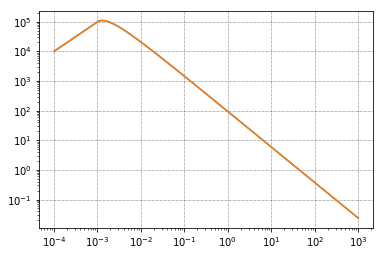

In [5]:
plt.plot(r, p)
plt.plot(r, values)

plt.xscale('log')
plt.yscale('log')
plt.grid()

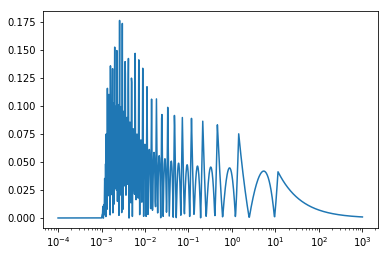

In [6]:
plt.plot(r, error)
plt.xscale('log')

# Gammas

In [2]:
def legendre(expression, degree):
    global omega
    roots, weights = np.polynomial.legendre.leggauss(degree)
    le = np.array([expression.subs(omega, 0.5 * x_i + 0.5).evalf() for x_i in roots])
    return 0.5 * sum(le * weights)

def laguerre(expression, degree):
    global tau
    roots, weights = np.polynomial.laguerre.laggauss(degree)
    la = np.array([expression.subs(tau, x_i).evalf() for x_i in roots])
    return sum(la * weights)

In [3]:
G, tau, omega, gamma = spy.symbols(r'G \tau \omega \gamma', real = True, positive = True)
r, m, x, y, z, a_1, a_2, a_3, phi_1, phi_2, phi_3 = spy.symbols("r m x y z a_1 a_2 a_3 \phi_1 \phi_2 \phi_3",
                                                                real = True, positive = True)

m_int = [i ** 2 / (a ** 2 + tau) for (i, a) in zip([x, y, z], [a_1, a_2, a_3])]
m_int = spy.sqrt(a_1 ** 2 * sum(m_int))

phi_x = x / (spy.sqrt(tau + a_1 ** 2) ** 3 * spy.sqrt(tau + a_2 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_y = y / (spy.sqrt(tau + a_2 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_z = z / (spy.sqrt(tau + a_3 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_2 ** 2))

In [4]:
t = tau ** gamma / (1 + tau ** gamma)
eq = spy.Eq(t, omega)

s0 = spy.solve(eq, tau)[0]
diff = s0.diff(omega).simplify()

In [5]:
rho_0, R_s = spy.symbols(r"\rho_0 R_s", real = True, positive = True)
M_s, r_s = spy.symbols(r"M_s \mathcal{R_s}", real = True, positive = True)

r_0 = spy.symbols("r_0", real = True, positive = True)
n = spy.symbols("n", real = True, positive = False)

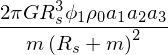

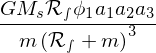

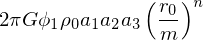

In [6]:
a_nfw = 2 * spy.pi * G * R_s ** 3 * rho_0 * a_1 * a_2 * a_3 * phi_1 / (m * (R_s + m)**2)
a_s =  G * M_s * r_s * a_1 * a_2 * a_3 * phi_1 / (m * (r_s + m)**3)
a_g = 2 * spy.pi * G * rho_0 * a_1 * a_2 * a_3 * (r_0 / m) ** n * phi_1
display(a_nfw)
display(a_s)
display(a_g)

In [7]:
r = 1
pos = [r, 0, 0]
axis = [1, 1, 1]
smbh.setTriaxalCoeffs(* axis)

const = [(phi_1, phi_x), (m, m_int), (x, pos[0]), (y, pos[1]), (z, pos[2]),
         (a_1, axis[0]), (a_2, axis[1]), (a_3, axis[2]),
        (G, smbh.G)]

c_nfw = [(R_s, 0.172493), (rho_0, 16167.089408)]
c_s = [(M_s, 1.56), (r_s, 0.002858)]
c_g = [(r_0, 1e-3), (n, 2.2), (rho_0, 52879035.263645)]

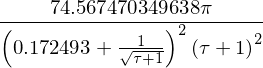

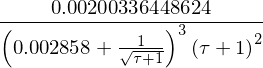

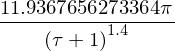

In [8]:
f_nfw = a_nfw.subs(const + c_nfw)
f_s = a_s.subs(const + c_s)
f_g = a_g.subs(const + c_g)

display(f_nfw)
display(f_s)
display(f_g)

In [14]:
acs = [f_nfw, f_s, f_g]
values = [smbh.darkMatterMass(r), smbh.stellarMassHernquist(r), smbh.gasMass(r)]

values = smbh.G * np.array(values) / r ** 2
labels = ['Dark matter', 'Stars', 'Gas']
gammas = np.logspace(-3, 2, 100)
degree = 50

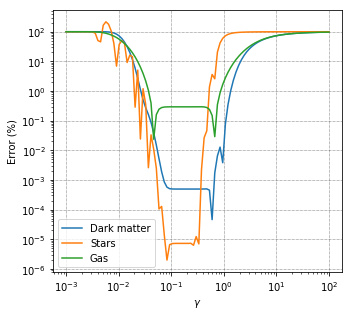

In [15]:
fig, ax = plt.subplots(figsize = (5, 4.5))

for i in range(3):
    val = values[i]
    a = (acs[i] * diff).subs(tau, s0)
    v = [legendre(a.subs(gamma, g), degree) for g in gammas]
    v = 100 * abs(v - val) / val
    ax.plot(gammas, v, label = labels[i])
    
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('Error (%)')
ax.legend()
ax.grid()

fig.tight_layout()

fig.savefig("gamma_error.png", dpi = 300)

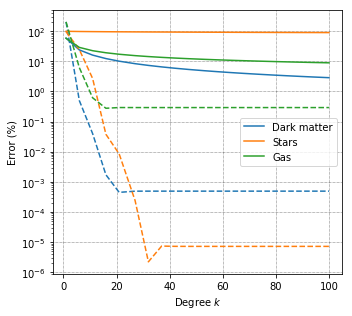

In [16]:
degrees = np.linspace(1, 100, 20).astype(int)

fig, ax = plt.subplots(figsize = (5, 4.5))

for i in range(3):
    val = values[i]
    a = acs[i] * spy.exp(tau)
    v = [laguerre(a, d) for d in degrees]
    v = 100 * abs(v - val) / val
    c = ax.plot(degrees, v, label = labels[i])[0].get_color()
    
    a = (acs[i] * diff).subs([(tau, s0), (gamma, 0.2)])
    v = [legendre(a, d) for d in degrees]
    v = 100 * abs(v - val) / val
    ax.plot(degrees, v, '--' ,c = c)
    
ax.set_yscale('log')

ax.set_xlabel(r'Degree $k$')
ax.set_ylabel('Error (%)')
ax.legend()

ax.grid()

fig.tight_layout()

fig.savefig("scheme_error.png", dpi = 300)